## Boundary Value Problems

**Nick Kern**
<br>
**Astro 9: Python Programming in Astronomy**
<br>
**UC Berkeley**

Reading: Chp 8 of Newman

In our study of second-order Ordinary Differential Equations (ODE), we have limited ourselves to solving **initial value** problems. In other words, we looked at problems where we were given an initial condition for all dependent variables of our system. Take, for example, our nonlinear pendulum, where we fed both a starting angle $\theta_0$ and an initial angular velocity $\omega_0$. This is also the case for our projectile example, where we fed initial positions $x_0,\ y_0$ and initial velocities, $v_{x,0},\ v_{y,0}$. We then used the techniques for solving ODEs for integrating the solution out to some ending time $t_2$.

There is another form of problem called **boundary value problems**, where we are given both an initial and final condition. In other words, the conditions straddle the boundary of the solution. Our task is to find the solution that passes through both the initial and final condition. One example of this can be seen going back to our projectile ODE: instead of feeding initial positions and initial velocities, we can feed an initial position and a final position, and solve for what initial velocity gives us a solution.

We can do this through trial and error, until we converge upon initial conditions that, when combined with our ODE, result in the desired final conditions. This is called, the **shooting method**.

<img src='imgs/shooting.png' width=500px/>
<center>Figure 8.9, Newman</center>

We could search for the right initial conditions by hand, but rarely in computational physics do we want to do anything by hand (the motto for this course), so we should come-up with algorithm that will do this for us. Let's start by re-formulating the problem.

Let's assume that we are given one initial condition, $x_i$ and one final condition, $x_f$. Our task is to search for another initial condition, $\theta_i$, that when combined with our differential equations, satisfies our given conditions, $x_i$ and $x_f$. One way to view this is to assume there is some function that maps the unknown initial condition to the ODE solution: $f(\theta_i) = x$. What we want is to find $\theta_i$ that makes $f(\theta_i) = x_f$. Another way to phrase this is that we want

\begin{align}
f(\theta_i) - x_f = 0
\end{align}

which means we want to find the **root** of the expression on the left as a function of $\theta_i$. We can do this with a root finding method, which we haven't yet discussed, so let's spend some time talking about one particular root-finding method called the **binary search** method.

### Binary Search Root Finding Method

The idea behind a root finding algorithm is this: we have some continuous function that at some point crosses the x-axis, which is to say that it's y-value is zero. This can happen multiple times, but it needs to happen at least once.

<img src='imgs/binary_search.png' width=400px/>
<center>Figure 6.3, Newman</center>

The idea behind the binary search method is to place two starting points, $x_1$ and $x_2$, separated by a wide distance which we will call $\ell$. We then evaluate our expression and compare the parity (positive or negative) of the expression at these two points. If they have opposite parity, then that means there is at least one root in the space between our points.

Next we take a new point, $x^{\prime}$, that is halfway between our two original points and evalute the parity of the expression there. If, by chance, the expression actually equals zero, then we have achieved our goal and we stop. This will almost never be the case, so typically what we do is compare its parity with our previous two points and select the one that has opposite parity. The root of the expression now must lie somewhere in between this midpoint and that original point, meaning we have narrowed down the possible locations where the root lies. In other words, $\ell$ is now equal to $\ell/2$. We repeat this until we have an $\ell$ that has converged to some tolerance and we stop and say the root is somewhere near the midpoint of our last iteration. 

**Example: Finding the Root of a quadratic**

Let's take the equation

\begin{align}
x^2 - 4x = 0
\end{align}

and use a binary search method to solve for its roots. You can probably guess that the equation looks something like

<img src='imgs/quadratic.png' width=350px/>

in which case we see there are two roots at $x = [0, 4]$. We therefore need to be careful, if we take $x_1$ and $x_2$ to be too far apart, we won't be able to find any roots because they will both be positive.

In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [71]:
# define function
def f(x):
    return x**2 - 4*x

# define starting points and starting values
x1 = -10
x2 = 1
y1 = f(x1)
y2 = f(x2)

# define root solution tolerance
tol = 1e-3

# binary search!
while abs(x2 - x1) >= tol:
    # get midpoint
    xprime = (x1 + x2)/2.0
    yprime = f(xprime)
    # change starting points depending on parity
    if yprime * y1 > 0:
        x1 = xprime
        y1 = yprime
    else:
        x2 = xprime
        y2 = yprime
        
xroot = (x1 + x2)/2
yroot = f(xroot)

### Breakout 1: L1 Lagrangian Point

There is a location between the Earth and the Moon where the mutual gravitational interaction has created a stable orbital location between them. We call these lagrangian points, and for a two-body system there are five of them.

<img src='imgs/lagrange_points.png' width=400px/>
<center>Example of the five L points for a two-body system of the Sun and Earth. In our case, we are looking at the Earth and the Moon.</center>

Let's solve for the distance away the L1 point is from Earth in a two-body system containing the Earth and the Moon. We can setup a force diagram and show that the acceleration vectors acting on an object at the L1 location can be written as

\begin{align}
\frac{GM}{r^2} - \frac{Gm}{(R-r)^2} = \omega^2r
\end{align}

where $G = 6.674\times10^{-11}$ m$^3$ kg$^{-1}$ sec$^{-2}$ is the gravitational constant, $M = 5.974\times10^{24}$ kg is the mass of the Earth, $m=7.348\times10^{22}$ kg is the mass of the Moon, $R=3.844\times10^{8}$ meters is the distance from the Earth to the Moon, and $\omega = 2.662\times10^{-6}$ sec$^{-1}$ is the angular velocity of the Moon's orbit.

1.
Use a binary search method to solve for the distance from the center of the Earth to the L1 point, with an accuracy to at least four significant figures.

Now that we have a root finding algorithm, we can return to the ODE and our boundary value problem.

**Example: Projectile Trajectory with Air Resistance**

Let's return to the problem of solving for a projecitle's trajectory subject to air resistance. We will assume that the initial firing angle is held constant at $\theta=35^\circ$. **What is the initial velocity that will give us a direct hit with a target on the ground at $x = 100$ meters?** Let's combine our ODE solver and our binary search method to answer this question. The expression we want to find the root of is

\begin{align}
x(y=0) = 100
\end{align}

In [6]:
# define derivative function
def f(r, t):
    # unpack array
    x = r[0]
    vx = r[1]
    y = r[2]
    vy = r[3]
    # assign derivatives
    fx = vx
    fvx = -np.pi*R**2*RHO*C/2/m*vx*np.sqrt(vx**2 + vy**2)
    fy = vy
    fvy = -g - np.pi*R**2*RHO*C/2/m*vy*np.sqrt(vx**2 + vy**2)
    # repack
    return np.array([fx, fvx, fy, fvy], dtype=np.float)

In [7]:
# Define RK4 algorithm with error estimate
def RK4_adaptive(f, r1, t1, y2, dt=1e-3, err_tol=1e-4):

    # Define initial condition
    r = r1.copy()

    # define a function for RK4 update
    def rk4_update(r, t, dt):
        # update value using RK4
        k1 = dt * f(r, t)
        k2 = dt * f(r+0.5*k1, t+0.5*dt)
        k3 = dt * f(r+0.5*k2, t+0.5*dt)
        k4 = dt * f(r+k3, t+dt)
        return r + (k1 + 2*k2 + 2*k3 + k4)/6.0

    # Iterate RK4 Method
    t = t1
    xpoints = []
    ypoints = []
    tpoints = []
    while r[2] >= y2:
        # append value of x to xpoints
        xpoints.append(r[0])
        ypoints.append(r[2])
        tpoints.append(t)

        # Enter error tolerance loop
        while True:
            ## Calculate estimated error ##
            # double step
            r1_a = rk4_update(r, t, dt).copy()
            r1 = rk4_update(r1_a, t+dt, dt).copy()
            # big step
            r2 = rk4_update(r, t, 2*dt).copy()

            # calculate total error
            eps_x = np.abs(r1[0] - r2[0])/30.0
            eps_y = np.abs(r1[2] - r2[2])/30.0
            eps_tot = np.sqrt(eps_x**2 + eps_y**2)

            # calculate rho
            rho = (dt*err_tol/eps_tot)**(1./4)

            # evaluate ideal step size
            if rho >= 1.0:
                if rho >= 2.0:
                    rho = 2.0
                break
            else:
                if rho < 0.5:
                    rho = 0.5
                dt *= 0.99*rho

        # update dt
        dt *= 0.99*rho

        # update r to the single step
        r = r1_a.copy()

        # update t
        t += dt
        
    xpoints = np.array(xpoints)
    ypoints = np.array(ypoints)
    tpoints = np.array(tpoints)
    
    # solve for when ball hits ground by extrapolating last two points
    # y = mx + b
    m = (ypoints[-1]-ypoints[-2])/(xpoints[-1]-xpoints[-2])
    b = ypoints[-1] - m*xpoints[-1]
    xfinal = (0 - b) / m
    yfinal = 0
    # t = nx + c
    n = (tpoints[-1]-tpoints[-2])/(xpoints[-1]-xpoints[-2])
    c = tpoints[-1] - n*xpoints[-1]
    tfinal = n * xfinal + c
    
    return tfinal, xfinal, yfinal

In [13]:
# Initial Conditions
g = 9.81
m = 1
R = 0.08
C = 0.47
RHO = 1.22

# create root function
def displacement(v_mag):
    theta0 = 30.0 * np.pi/180
    vx0 = v_mag * np.cos(theta0)
    vy0 = v_mag * np.sin(theta0)
    r1 = np.array([0, vx0, 0, vy0])

    # run solver
    tf, xf, yf = RK4_adaptive(f, r1, 0, 0, dt=1e-5, err_tol=1e-6)
    return xf - 100.0

/Users/nkern/Software/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in double_scalars


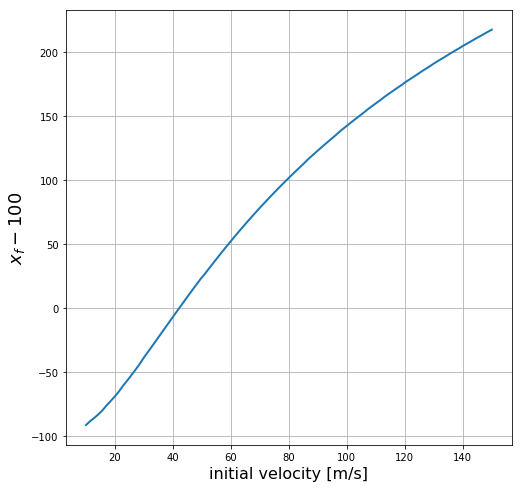

In [14]:
# Let's just plot the function to get an idea of what it looks like
v = np.linspace(10,150,100)
y = np.array(list(map(displacement, v)))

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.grid(True)
ax.plot(v, y, linewidth=2)
ax.set_xlabel('initial velocity [m/s]', fontsize=16)
ax.set_ylabel(r'$x_f - 100$', fontsize=18)

In [12]:
# use binary search to get root within 4 sig figs
# define starting points and starting values
x1 = 1 
x2 = 150
y1 = displacement(x1)
y2 = displacement(x2)

# define root solution tolerance
tol = 1e-4

# binary search!
while abs(x2-x1) > tol:
    # get midpoint
    xprime = (x1+x2)/2.0
    yprime = displacement(xprime)
    # change starting points depending on parity
    if yprime * y1 < 0:
        x2 = xprime
        y2 = yprime

    else:
        x1 = xprime
        y1 = yprime

xroot = (x1+x2)/2
yroot = displacement(xroot)

print("Optimal initial velocity is {:.2f} m/s".format(xroot))

Optimal initial velocity is 42.21 m/s


/Users/nkern/Software/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in double_scalars


### Breakout 2: Nonlinear Pendulum

Let's return to the Nonlinear pendulum and use the methods we've learned to solve a boundary value problem. Let's assume the same set-up as before, except use $\ell = 1.0$ meters, and this time vary the initial angular velocity, $\omega_i$, to find when $\theta = f$ when $t = 1$. Note that you might want to draw from the code in `NumODE_Breakout3.py`, which has the RK4 solver for the 2nd-order ODE.

1.
First plot the function you want to find the root of as a function of $\omega_i$ from $0 < \omega_i < 4$ radians / second. What happens when $\omega_i \sim 2$ radians / sec?

2.
Using your intuition from the previous plot, use a binary search method to find the $\omega_i$ given the conditions of $\theta_i=\pi/3$ when $t_i = 0$ and $\theta_f=0$ when $t_f = 3$ seconds.